<a href="https://colab.research.google.com/github/Prathyusha-Akundi/Skin-Classification/blob/main/multiscale_input_featurewiseNorm_ISIC20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Upwork/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download cdeotte/jpeg-melanoma-256x256
! mkdir isic2020
! unzip jpeg-melanoma-256x256.zip -d isic2020

Streaming output truncated to the last 5000 lines.
  inflating: isic2020/train/ISIC_8512716.jpg  
  inflating: isic2020/train/ISIC_8513112.jpg  
  inflating: isic2020/train/ISIC_8513649.jpg  
  inflating: isic2020/train/ISIC_8514170.jpg  
  inflating: isic2020/train/ISIC_8514989.jpg  
  inflating: isic2020/train/ISIC_8515165.jpg  
  inflating: isic2020/train/ISIC_8515281.jpg  
  inflating: isic2020/train/ISIC_8515582.jpg  
  inflating: isic2020/train/ISIC_8515674.jpg  
  inflating: isic2020/train/ISIC_8516181.jpg  
  inflating: isic2020/train/ISIC_8516223.jpg  
  inflating: isic2020/train/ISIC_8516516.jpg  
  inflating: isic2020/train/ISIC_8516631.jpg  
  inflating: isic2020/train/ISIC_8516659.jpg  
  inflating: isic2020/train/ISIC_8516922.jpg  
  inflating: isic2020/train/ISIC_8517305.jpg  
  inflating: isic2020/train/ISIC_8517492.jpg  
  inflating: isic2020/train/ISIC_8518406.jpg  
  inflating: isic2020/train/ISIC_8519222.jpg  
  inflating: isic2020/train/ISIC_8519402.jpg  
  inflati

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model


filterwarnings('ignore')
np.random.seed(101)
EFNS = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, 
        EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]

In [3]:
root_path = '/content/isic2020/'
IMAGE_DIR = ( '/content/isic2020/train')
panda_path = os.path.join(root_path, 'train.csv')
print(len(os.listdir(IMAGE_DIR)))
#os.path.join

33126


In [4]:
def preprocess(df):
    for index, img in enumerate(df['image_name']):
        img = img+'.jpg'
        df['image_name'][index]=img
    # df.drop(['UNK'], axis=1, inplace=True)

In [5]:
def train_val_test_split(df, test_len=1000, val_ratio=0.2):
    test_rows = (np.random.rand(1000)*df.shape[0]).astype(int)
    test_df =  df.iloc[test_rows]
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df.drop(test_rows, axis=0, inplace=True)
    df = df.reset_index().drop(['index'], axis=1)
    val_rows = (np.random.rand(int(val_ratio*df.shape[0]))*df.shape[0]).astype(int)
    val_df = df.iloc[val_rows]
    df.drop(val_rows, axis=0, inplace=True)
    val_df = val_df.reset_index().drop(['index'], axis=1)
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df = df.reset_index().drop(['index'], axis=1)
#     int_dict = {'MEL':int, 'NV':int, 'BCC':int, 'AK':int, 'BKL':int, 'DF':int, 'VASC':int, 'SCC':int}
#     df = df.astype(int_dict) 
#     val_df = val_df.astype(int_dict)
#     test_df = test_df.astype(int_dict)
    return df, val_df, test_df

In [6]:
full_df = pd.read_csv(panda_path)
# one_hot = pd.get_dummies(full_df['target'])
# one_hot.columns = ['benign','malignant']
# one_hot.head()

In [7]:
# full_df = full_df.drop('target',axis = 1)
# # Join the encoded df
# full_df = full_df.join(one_hot)
# full_df.head()

In [8]:
preprocess(full_df)
train_df, val_df, test_df = train_val_test_split(full_df)
labels = train_df.benign_malignant.unique()
print(labels)
train_df.head()

['benign' 'malignant']


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011.jpg,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719.jpg,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212.jpg,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279.jpg,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268.jpg,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [9]:
print(len(train_df[train_df['benign_malignant']=='benign'])/len(train_df[train_df['benign_malignant']=='malignant']))
print(len(val_df[val_df['benign_malignant']=='benign'])/len(val_df[val_df['benign_malignant']=='malignant']))
print(len(test_df[test_df['benign_malignant']=='benign'])/len(test_df[test_df['benign_malignant']=='malignant']))

57.60356347438753
46.97014925373134
61.5


In [10]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [11]:
def get_segmentation_model(weights_path, inputs=None):
  # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
  INPUT_CHANNELS = 3
  # Number of output masks (1 in case you predict only one type of objects)
  OUTPUT_MASK_CHANNELS = 1
  # Pretrained weights
  def double_conv_layer(x, size, dropout=0.40, batch_norm=True, name = None):
    
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same',name=name)(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

  dropout_val=0.50
    
  if inputs is None:  
    inputs = Input((256, 256, INPUT_CHANNELS))
  axis = 3
  filters = 32

  conv_256 = double_conv_layer(inputs, filters)
  pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_256)

  conv_112 = double_conv_layer(pool_112, 2*filters)
  pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

  conv_56 = double_conv_layer(pool_56, 4*filters)
  pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

  conv_28 = double_conv_layer(pool_28, 8*filters)
  pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

  conv_14 = double_conv_layer(pool_14, 16*filters)
  pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

  conv_7 = double_conv_layer(pool_7, 32*filters, name='features')

  up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
  up_conv_14 = double_conv_layer(up_14, 16*filters)

  up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
  up_conv_28 = double_conv_layer(up_28, 8*filters)

  up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
  up_conv_56 = double_conv_layer(up_56, 4*filters)

  up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
  up_conv_112 = double_conv_layer(up_112, 2*filters)

  up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_256], axis=axis)
  up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

  conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
  conv_final = Activation('sigmoid')(conv_final)
  pred = Reshape((256,256))(conv_final)
  model = Model(inputs, pred, name="UNET_256")
  model.load_weights(weights_path)
  return model

In [12]:
segmentation_weights = '/content/drive/MyDrive/Upwork/Skin Classification/segmentation_weights/segmentation_256_unet_final'
segmentator = get_segmentation_model(weights_path=segmentation_weights)
segmentator.trainable = False

In [13]:
target_w = 256
target_h = 256

def crop_mask_prep(im):
    im = np.reshape(im,(1,target_w,target_h,3))
    im = im*(1./255)
    mask = segmentator.predict(im)
    im = np.squeeze(im)
    mask = np.squeeze(mask)
    mask_ = np.dstack((mask,mask,mask))
    mask_ = np.uint8(mask_*255)
    try:
        maskgray = cv2.cvtColor(mask_,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(maskgray,127,255,cv2.THRESH_BINARY)
        # find contours 
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(contour) for contour in contours]
        cnt = contours[np.argmax(areas)]
        # straight rectangle
        x,y,w,h = cv2.boundingRect(cnt)
        final = im[y:y+h, x:x+w]
        final = cv2.resize(final, (target_w,target_h))
        final = np.float32(final*255)
    except:
        final = np.float32(im*255)

    
    return final

In [14]:
def get_generator(df=train_df, image_dir=IMAGE_DIR, x_col='image_name', y_cols='benign_malignant', shuffle=True, batch_size=32, seed=42, target_w = 256, target_h = 256):
    
    
    print("getting  generator...") 
    # normalize images
    image_generator1 = ImageDataGenerator(
        # rescale=1./255,  
        # samplewise_center=True,
        # samplewise_std_normalization=True,
        # featurewise_center = True,
        # featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        # rotation_range = 15,
#         preprocessing_function = preprocessing
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator1 = image_generator1.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    image_generator2 = ImageDataGenerator(
        # rescale=1./255,  
        # samplewise_center=True,
        # samplewise_std_normalization=True,
        # featurewise_center = True,
        # featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        # rotation_range = 15,
        preprocessing_function = crop_mask_prep
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator2= image_generator2.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    while True:
        X1i = generator1.next()
        X2i = generator2.next()
        yield [X1i[0], X2i[0]], X2i[1]

In [15]:
batch_size = 32
train_generator = get_generator(df = train_df, batch_size = batch_size)
valid_generator = get_generator(df = val_df, batch_size = batch_size)
test_generator = get_generator(df = test_df, batch_size = batch_size)

In [16]:
class_labels = train_df['benign_malignant'].values
class_labels.shape

(26313,)

In [17]:
# freq_pos, freq_neg = compute_class_freqs(class_labels)

# pos_weights = freq_neg
# neg_weights = freq_pos

In [18]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        
        y_true = tf.cast(y_true, tf.float32)
        

        
            # for each class, add average weighted loss for that class 
        loss = K.mean(-(pos_weights*y_true*K.log(y_pred+epsilon)
                          + neg_weights*(1-y_true)*K.log((1-y_pred)+epsilon)))
        return loss
    
    return weighted_loss

In [19]:
x, y = next(train_generator)

getting  generator...
Found 26313 validated image filenames belonging to 2 classes.
Found 26313 validated image filenames belonging to 2 classes.


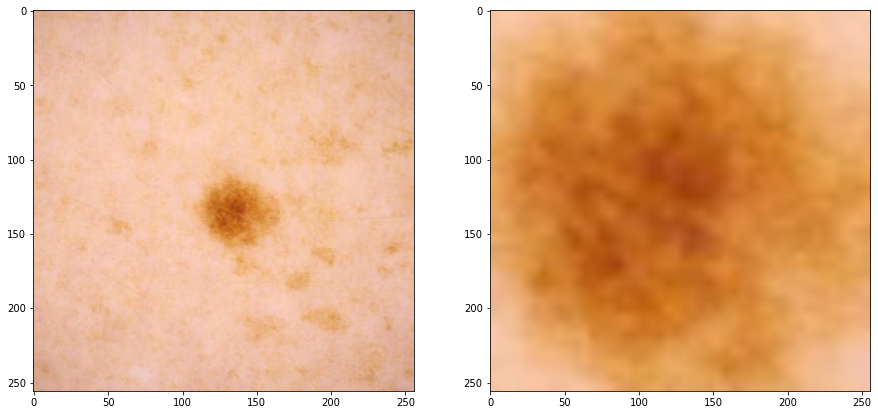

In [20]:
i = 8
f,ax = plt.subplots(1,2,figsize=(15,8))


ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [21]:
x, y = next(valid_generator)


getting  generator...
Found 6428 validated image filenames belonging to 2 classes.
Found 6428 validated image filenames belonging to 2 classes.


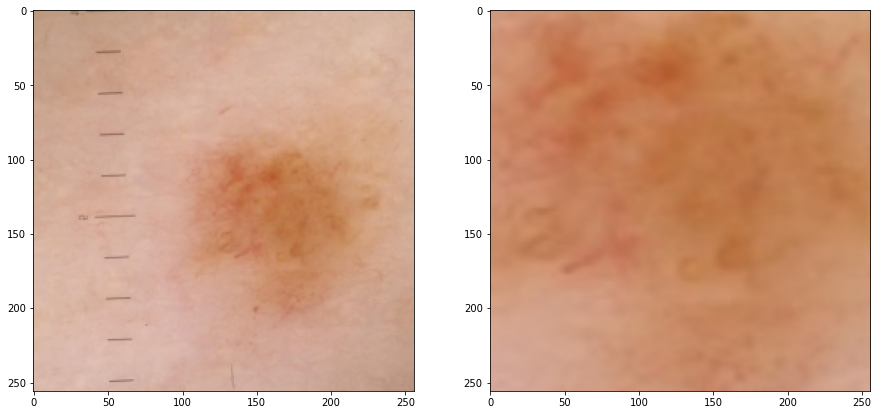

In [22]:
i = 9
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [23]:
(np.max(x[0][i]),np.max(x[1][i]))

(229.0, 216.82812)

getting  generator...
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


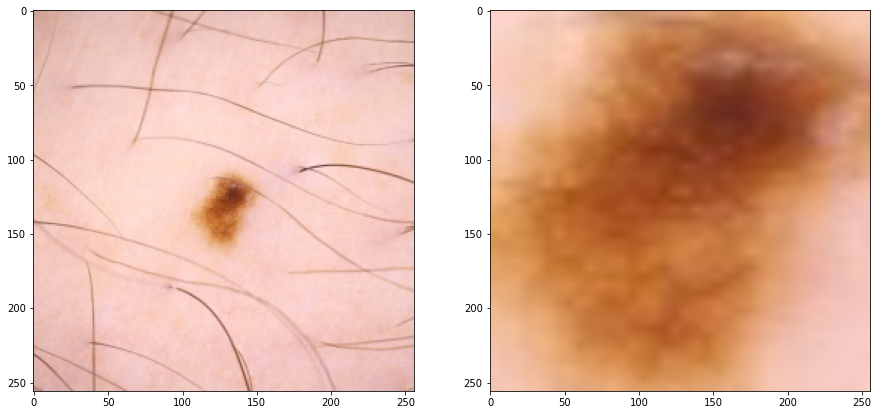

In [24]:
x, y = next(test_generator)

i = 10
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [25]:
(np.max(x[0][i]),np.max(x[1][i]))

(255.0, 255.0)

In [26]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [27]:
from sklearn.utils import class_weight

In [28]:
y_train = train_df.benign_malignant.values

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
print(class_weights)

[ 0.50868002 29.30178174]


In [29]:
np.unique(y_train)

array(['benign', 'malignant'], dtype=object)

In [30]:
class_weights = {0: class_weights[0],1: class_weights[1]}

In [31]:
def get_lr_callback():
    lr_start   = 0.000003
    lr_max     = 0.000020 
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [32]:

def get_classifier_model(dim = 256, ef = 0):
    ### Base Model ###
    # Input
    
    input1 = Input(shape = (dim, dim, 3))
    input2 = Input(shape = (dim, dim, 3))
    # Base EfficientNet pretrained model
    base = EFNS[ef](
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        # pooling = 'avg'
    )
    x1 = base(input1)    
    x1 = Conv2D(512, (3, 3), padding='same',name='effnet_features1', activation = "relu")(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    # x1 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features1')(x1)
    
    x2 = base(input2)
    x2 = Conv2D(512, (3, 3), padding='same',name='effnet_features2', activation = "relu")(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
    # x2 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features2')(x2)
    
    x = tf.keras.layers.Concatenate()([x1,x2])
    # x = ReLU()(x)
    # x = Dense(512, activation = "relu")(x)
    # x = Dropout(0.2)(x)

    x = Dense(128, activation = "relu")(x)
   
    
    # x = base(inputs)
    # x = Conv2D(1024, (3, 3), padding='same',name='effnet_features')(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x1)

    ### Rebuild top ###
    x = Dense(1, activation = "sigmoid")(x)


    model = Model(inputs = [input1, input2], outputs = x)
#
    model.compile(optimizer= 'adam', loss=focal_loss(), metrics=[tf.keras.metrics.AUC()])
    
    # model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(from_logits=False)])
    # model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=[tf.keras.metrics.AUC(from_logits=False)])
    return model

In [33]:
model = get_classifier_model()

16719872/16705208 [==============================] - 0s 0us/step


In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 8, 8, 1280)   4049571     ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, verbose=1)
checkpoint_filepath = '/content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2020'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [36]:
STEP_SIZE_TRAIN=len(train_df)//batch_size
STEP_SIZE_VALID= len(val_df)//batch_size
STEP_SIZE_TEST=len(test_df)//batch_size

In [48]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,verbose=1,
                        validation_steps=STEP_SIZE_VALID, epochs=25, callbacks=[callback, model_checkpoint_callback, get_lr_callback()], class_weight=class_weights)

Epoch 1/25
822/822 [==============================] - ETA: 0s - loss: 0.0613 - auc: 0.7631
Epoch 00001: val_auc improved from -inf to 0.73025, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2020
822/822 [==============================] - 2310s 3s/step - loss: 0.0613 - auc: 0.7631 - val_loss: 0.0416 - val_auc: 0.7303 - lr: 3.0000e-06
Epoch 2/25
822/822 [==============================] - ETA: 0s - loss: 0.0525 - auc: 0.8458
Epoch 00002: val_auc improved from 0.73025 to 0.79817, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2020
822/822 [==============================] - 2324s 3s/step - loss: 0.0525 - auc: 0.8458 - val_loss: 0.0265 - val_auc: 0.7982 - lr: 6.4000e-06
Epoch 3/25
822/822 [==============================] - ETA: 0s - loss: 0.0463 - auc: 0.8869
Epoch 00003: val_auc improved from 0.79817 to 0.82155, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input

In [37]:
def plot_train_hist(hist):
    # Plot training & validation accuracy values
    plt.plot(hist.history['auc'])
    plt.plot(hist.history['val_auc'])
    plt.title('Model AUC')
    plt.ylabel('Auc')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [38]:
model.load_weights(checkpoint_filepath)

In [39]:
loss, val_auc = model.evaluate_generator(valid_generator,steps=STEP_SIZE_VALID,verbose=1)
print(val_auc)

200/200 [==============================] - 384s 2s/step - loss: 0.0126 - auc: 0.8794
0.8793823719024658


In [40]:
test_loss, test_auc = model.evaluate_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
print(test_auc)

31/31 [==============================] - 55s 2s/step - loss: 0.0116 - auc: 0.9034
0.9033941626548767
